In [1]:
import numpy as np
# import pygame
import gymnasium as gym
from gym import spaces
# from spaces import MultiBinary
import json
import math

def get_vectormap(vectormap):
    f = open(vectormap)
    data = json.load(f)
    return data

def get_image_size(vectormap, scaling = 10):
    # get the size of the image
    x = []
    y = []
    for line in vectormap:
        for point in line:
            x.append(line[point]['x'])
            y.append(line[point]['y'])
    return math.ceil(max(x) - min(x)) * scaling + 1,  math.ceil(max(y) - min(y)) * scaling  + 1

def get_image_min_max(vectormap):
    # get the size of the image
    x = []
    y = []
    for line in vectormap:
        for point in line:
            x.append(line[point]['x'])
            y.append(line[point]['y'])
    return min(x), min(y), max(x), max(y)

def get_map_channel(vectormap, image_size_x, image_size_y, x_min, y_min, scaling = 10):
    # first channel is the map, which is a binary image where 0 is empty space and 1 is occupied space
    map_channel = np.zeros((image_size_x, image_size_y))
    # count_horizontal = 0
    # count_vertical = 0
    # count_diagonal = 0
    for line in vectormap:
        start_x = round((line['p0']['x'] - x_min) * scaling)
        start_y = round((line['p0']['y'] - y_min) * scaling)
        end_x = round((line['p1']['x'] - x_min) * scaling)
        end_y = round((line['p1']['y'] - y_min) * scaling)
        
        # horizontal line
        if start_y == end_y:
            # continue
            start_x, end_x = min(start_x, end_x), max(start_x, end_x)
            map_channel[start_x:end_x, start_y] = 1
            # count_horizontal += 1
        # vertical line
        elif start_x == end_x:
            # continue
            start_y, end_y = min(start_y, end_y), max(start_y, end_y)
            map_channel[start_x, start_y:end_y] = 1
            # count_vertical += 1
        # diagonal line
        else:
            # along x axis
            (start_x, start_y), (end_x, end_y) = sorted([(start_x, start_y), (end_x, end_y)], key=lambda x: x[0])
            slope = (end_y - start_y) / (end_x - start_x)
            for x in range(start_x, end_x + 1):
                y = start_y + slope * (x - start_x)
                map_channel[round(x), round(y)] = 1
            
            # along y axis
            (start_x, start_y), (end_x, end_y) = sorted([(start_x, start_y), (end_x, end_y)], key=lambda x: x[1])
            slope = (end_x - start_x) / (end_y - start_y)
            for y in range(start_y, end_y + 1):
                x = start_x + slope * (y - start_y)
                map_channel[round(x), round(y)] = 1
            # count_diagonal += 1
    # print("horizontal: ", count_horizontal, "vertical: ", count_vertical, "diagonal: ", count_diagonal)
    return map_channel

In [2]:
def transform_xy_to_map(x, y, x_min, y_min, scaling = 10):
    return round((x - x_min) * scaling), round((y - y_min) * scaling)


def get_agent_channel(agent_x, agent_y, agent_dims, x_min, y_min, image_size_x, image_size_y, scaling = 10):
    agent_channel = np.zeros((image_size_x, image_size_y))
    agent_x, agent_y = transform_xy_to_map(agent_x, agent_y, x_min, y_min, scaling)
    for i in range(agent_x - agent_dims[0]//2, agent_x + agent_dims[0]//2):
        for j in range(agent_y - agent_dims[1]//2, agent_y + agent_dims[1]//2):
            agent_channel[i, j] = 1
    return agent_channel


In [3]:
def line_coverage_channel_sweep(p0, p1, coverage_radius, coverage_channel, map_channel, x_min, y_min, scaling = 10, increment = 0.5):
    #increment is equal to the value of 1 with regards to the scaling factor, so if the scaling factor is 10, increment is 0.5*1/10 = 0.05 meters
    #this function increments along a path line, and draws in the coverage radius by extending lines perpendicular to the path line.
    #the extended lines also increment and set the coverage channel to 1. This happens all along the path line giving us where the robot has covered.
    # dz = increment / scaling
    radius_scaled = coverage_radius*scaling
    segment_length = np.linalg.norm(p1 - p0)
    segment_length_scaled = segment_length*scaling
    # m = (p1[1] - p0[1])/(p1[0] - p0[0])
    # m_inv = -1/m
    theta = math.atan2((p1[1] - p0[1]),(p1[0] - p0[0]))
    tangent_line_theta = math.atan2(-(p1[0] - p0[0]),(p1[1] - p0[1]))
    d_coverage_radius = round(radius_scaled/increment)
    d_line_length = round(segment_length_scaled/increment)
    #position along the main line
    pos = [(p0[0]-x_min)*10, (p0[1]-y_min)*10]
    heading_rad_inc = [increment*math.cos(tangent_line_theta), increment*math.sin(tangent_line_theta)]
    heading_segment_inc = [increment*math.cos(theta), increment*math.sin(theta)]
    for d_ll in range(d_line_length + 1):
        rad_pos = pos
        rad_neg = pos
        stop_pos = False
        stop_neg = False
        for d_cr in range(d_coverage_radius + 1):
            if map_channel[round(rad_pos[0]),round(rad_pos[1])] == 0 and not stop_pos:
                coverage_channel[round(rad_pos[0]),round(rad_pos[1])] = 1
                rad_pos = [rad_pos[0] + heading_rad_inc[0], rad_pos[1] + heading_rad_inc[1]]
            else:
                stop_pos = True
            if map_channel[round(rad_neg[0]),round(rad_neg[1])] == 0 and not stop_neg:
                coverage_channel[round(rad_neg[0]),round(rad_neg[1])] = 1
                rad_neg = [rad_neg[0] - heading_rad_inc[0], rad_neg[1] - heading_rad_inc[1]]
            else:
                stop_neg = True
        pos = [pos[0] + heading_segment_inc[0], pos[1] + heading_segment_inc[1]]
    
    for d_circ in range(d_coverage_radius + 1):
        rad_pos = pos
        rad_neg = pos
        stop_pos = False
        stop_neg = False
        d_coverage_circle = round(math.sqrt(d_coverage_radius ** 2 - (d_circ*increment) ** 2))
        
        for d_cr in range(d_coverage_circle + 1):
            if map_channel[round(rad_pos[0]),round(rad_pos[1])] == 0 and not stop_pos:
                coverage_channel[round(rad_pos[0]),round(rad_pos[1])] = 1
                rad_pos = [rad_pos[0] + heading_rad_inc[0], rad_pos[1] + heading_rad_inc[1]]
            else:
                stop_pos = True
            if map_channel[round(rad_neg[0]),round(rad_neg[1])] == 0 and not stop_neg:
                coverage_channel[round(rad_neg[0]),round(rad_neg[1])] = 1
                rad_neg = [rad_neg[0] - heading_rad_inc[0], rad_neg[1] - heading_rad_inc[1]]
            else:
                stop_neg = True
        pos = [pos[0] + heading_segment_inc[0], pos[1] + heading_segment_inc[1]]

    return coverage_channel

def sweep_path(path, coverage_radius, coverage_channel, map_channel, x_min, y_min, scaling = 10, increment = 0.5):
    for p0, p1 in path:
        coverage_channel = line_coverage_channel_sweep(p0, p1, 0.5, coverage_channel, map_channel, x_min, y_min, scaling = 10, increment = 0.5)
    return coverage_channel



In [4]:
vectormap = get_vectormap("../GDC1.vectormap.json")
image_size_x, image_size_y = get_image_size(vectormap)
print("dims:", image_size_x, image_size_y)
x_min, y_min, x_max, y_max = get_image_min_max(vectormap)
map_channel = get_map_channel(vectormap, image_size_x, image_size_y, x_min, y_min)


# initialize agent channel
agent_channel = np.zeros((image_size_x, image_size_y))
agent_x = 7
agent_y = -7
agent_dims = np.array([4, 4])
agent_channel = get_agent_channel(agent_x, agent_y, agent_dims, x_min, y_min, image_size_x, image_size_y)




dims: 891 691


In [5]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [6]:
def vector_norm(v):
    return np.linalg.norm(v, axis=-1)

def distance_point_to_segment_vectorized(p, v, w):
    # p is a single point (2,), v and w are arrays of points (n, 2)
    segment_vector = w - v  # Vector from each v to w
    vp = p - v  # Vector from each v to point p
    segment_length_squared = np.sum(segment_vector**2, axis=1)
    
    # Ensure we do not divide by zero
    segment_length_squared[segment_length_squared == 0] = 1.0
    
    # Project point onto the line (segment) vector
    t = np.clip(np.sum(vp * segment_vector, axis=1) / segment_length_squared, 0, 1)
    projection = v + t[:, np.newaxis] * segment_vector
    distance = vector_norm(p - projection)
    return distance

def segment_to_segments_distance(s1_p1, s1_p2, segments):
    # Segments is an (n, 2, 2) array
    s2_p1 = segments[:, 0, :]
    s2_p2 = segments[:, 1, :]
    
    # Distances from s1_p1 to all segments in segments
    dist_p1 = distance_point_to_segment_vectorized(s1_p1, s2_p1, s2_p2)
    dist_p2 = distance_point_to_segment_vectorized(s1_p2, s2_p1, s2_p2)
    
    # Distances from all s2_p1 to segment s1
    dist_p3 = distance_point_to_segment_vectorized(s2_p1, s1_p1, s1_p2)
    dist_p4 = distance_point_to_segment_vectorized(s2_p2, s1_p1, s1_p2)
    
    # Find the minimum distance for each segment
    min_distances = np.min([dist_p1, dist_p2, dist_p3, dist_p4], axis=0)
    return min_distances

def minimum_distance_to_segments(start, end, segments):
    # Calculate the minimum distance from segment (start, end) to all segments
    min_distances = segment_to_segments_distance(start, end, segments)
    # Find the minimum distance overall
    return np.min(min_distances)

In [7]:
from Astar import Astar
print(map_channel.shape)
inverted_map_channel = 1 - map_channel
astar = Astar(inverted_map_channel, 4)

# astar.a_star_search(inverted_map_channel, start, end)
# path = astar.path

# for point in path:
#     map_channel[point[0], point[1]] = 1

(891, 691)


In [8]:
start = np.array([ 200, 420])
end = np.array([800, 500])
astar.a_star_search(start, end)
path = astar.path
path = astar.SmoothPath(path)
for point in path:
    map_channel[point[0], point[1]] = 1

The destination cell is found
The Path is 


<Axes: >

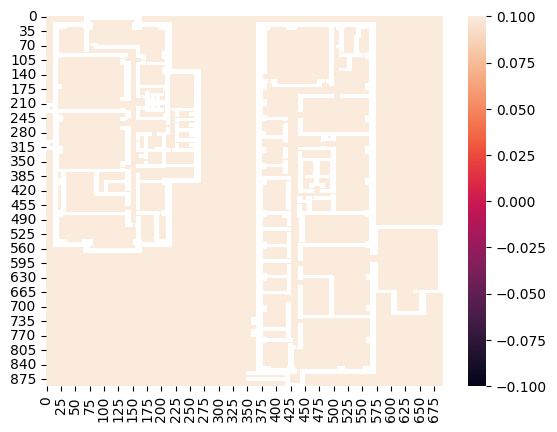

In [11]:
import seaborn as sns

sns.heatmap(astar.weighted_grid)

In [ ]:
from RRT import InformedRRTStar as RRT

rrt = RRT(vectormap, x_min, x_max, y_min, y_max)
start = np.array([-7.958, -23.98])
end = np.array([-8.588, -14.148])
print(minimum_distance_to_segments(start, end, rrt.vectormap))
# if rrt.Plan(start, end):
#     path = rrt.GetPath()
#     print(path)

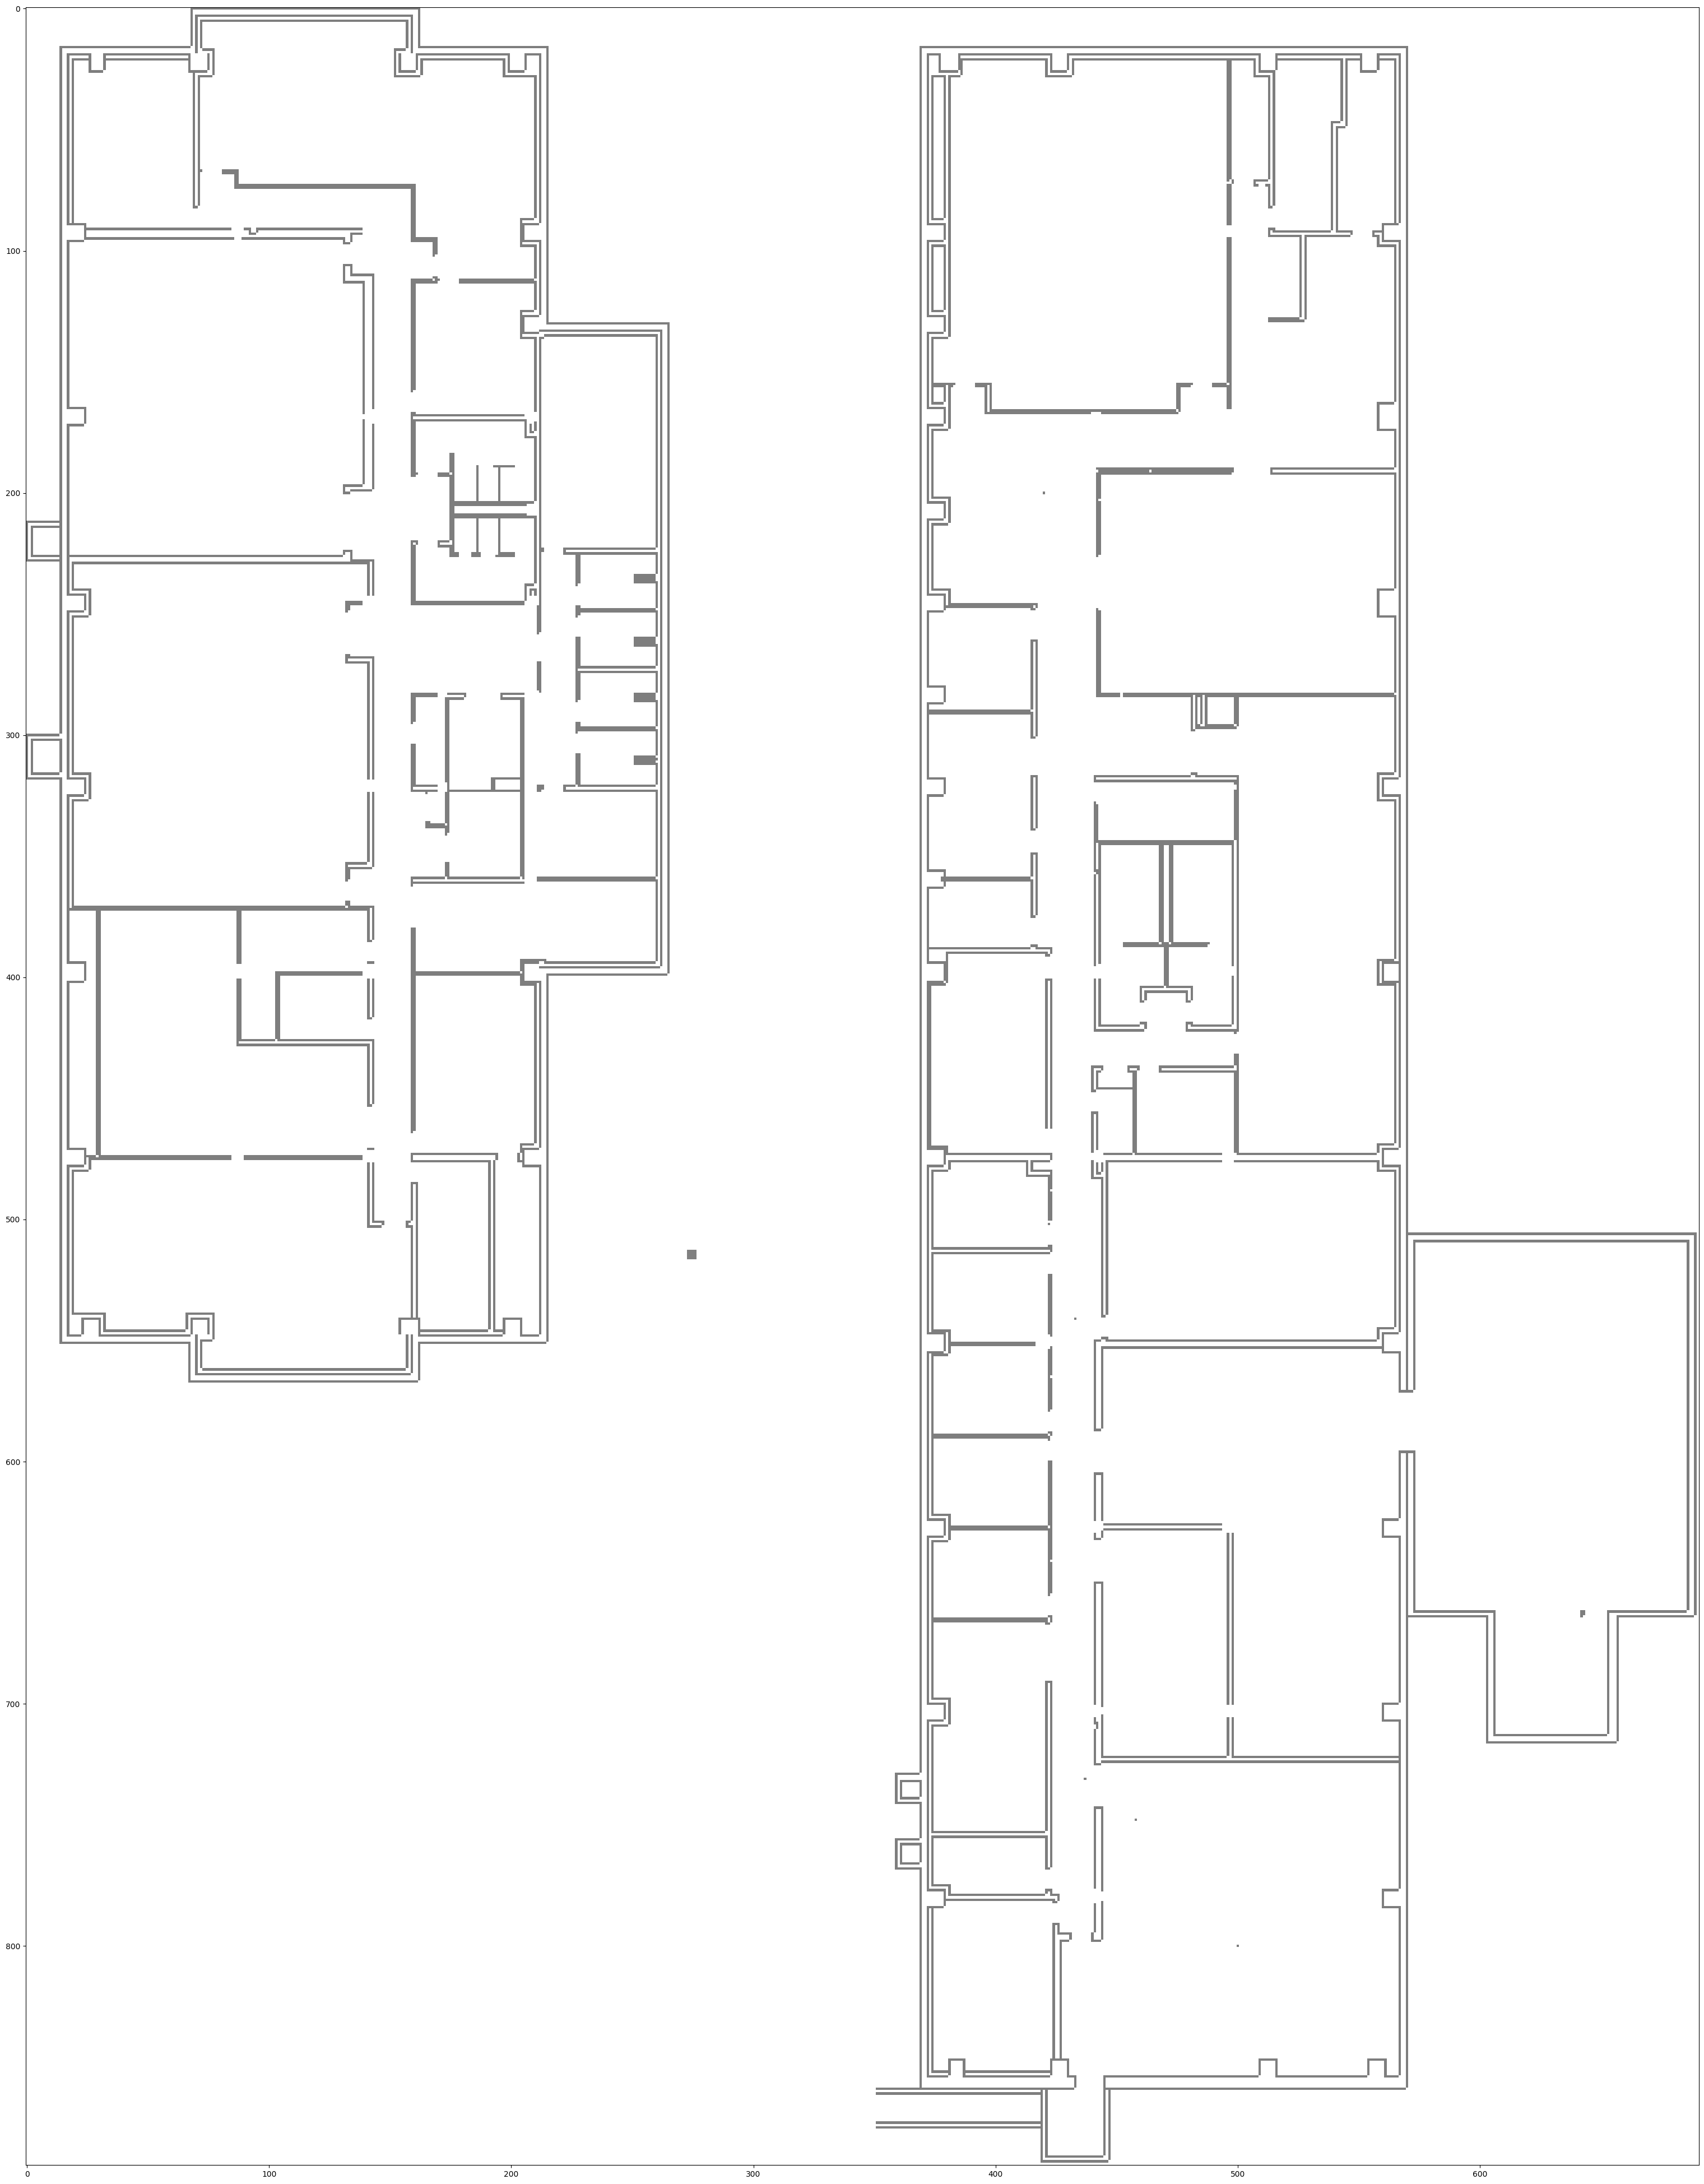

In [9]:

from matplotlib import pyplot as plt
# map_channel = np.rot90(map_channel)
# agent_channel = np.rot90(agent_channel)
plt.figure(figsize=(50, 50))
plt.imshow(map_channel, cmap='binary')
plt.imshow(agent_channel, cmap='binary', alpha=0.5)
# plt.imshow(coverage_channel,cmap='binary', alpha=0.25)

In [67]:
import numpy as np
# import pygame
from gymnasium.spaces import MultiBinary
import gymnasium as gym
from gym import spaces
import json
import math
import Astar as astar
class CCPP_Env(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 20}

    def __init__(self, render_mode=None, map_file = "FinalProject/GDC1.vectormap.json", agent_dims = np.array([1,1]), agent_loc = np.array([0,0]), scaling = 10, coverage_radius = 1):
        self.vectormap = get_vectormap(map_file)
        
        # get the size of the image
        self.image_size_x, self.image_size_y = get_image_size(self.vectormap)

        #get min values for the offset
        self.x_min, self.y_min, self.x_max, self.y_max = get_image_min_max(self.vectormap)

        # get the map channel
        self.map_channel = get_map_channel(self.vectormap, self.image_size_x, self.image_size_y, self.x_min, self.y_min)
        # initialize space visited channel
        self.space_visited_channel = np.zeros((self.image_size_x, self.image_size_y))
        # initialize agent channel
        self.agent_dims = np.array(agent_dims * scaling).astype(int)
        self.agent_channel = get_agent_channel(agent_loc[0], agent_loc[1], self.agent_dims, self.x_min, self.y_min, scaling)

        # make the observation space with 3 channels: 1 for the map, 1 for the agent, 1 for spaces visited
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,self.image_size_x, self.image_size_y), dtype=np.uint8)
        
        # #navigation goal input, 2D vector
        self.astar = Astar(self.vectormap, agent_dims[0])
        self._action_space = spaces.Box(low=np.array([self.x_min, self.y_min, -1]), high=np.array([self.x_max, self.y_max, 1]), dtype=np.float32)

        self._navigation = np.array([0.0,0.0])  

        self._scaling = scaling
        self._coverage_radius = coverage_radius

    def reset(self):
        self.space_visited_channel = np.zeros((self.image_size_x, self.image_size_y))
        self.agent_channel = get_agent_channel(0, 0, self.agent_dims, self.x_min, self.y_min, self.image_size_x, self.image_size_y)
        self._navigation = np.array([0.0,0.0])
        return self.get_observation()
    
    def get_observation(self):
        return np.array([self.map_channel, self.agent_channel, self.space_visited_channel])
    
    def get_reward(self):
        return 0
    
    def step(self, action):
        # check if action is termination 
        if action[2] < 0:
            return self.get_observation(), get_reward(), True, {}
        # get path from agent to navigation goal
        viable = self.astar.a_star_search(self.agent_loc, self._navigation)
        path, successful = self.astar.SmoothPath(), viable
        if not successful:
            return self.get_observation(), -1, False, {}
        self.space_visited_channel = sweep_path(path, self._coverage_radius, self.space_visited_channel, self.map_channel, self.x_min, self.y_min, self._scaling)
        self.agent_loc = self._navigation
        self.agent_channel = get_agent_channel(self.agent_loc[0], self.agent_loc[1], self.agent_dims, self.x_min, self.y_min, self.image_size_x, self.image_size_y)
        return self.get_observation(), 0, False, {}
        

In [ ]:
# import cupy as np    
start, end = np.array([0, 0]), np.array([1, 1])
print(ClosestDistanceToWall(vectormap_arr, start, end))
def ClosestDistanceToWall(self, start, end):
        # use cupy to parallelize the computation of the min distance of the line segment (from start to end) to the walls in the vector map
        # the vector map is an np array of 2d points
        # the line segment is defined by the start and end points
        # the function should return the minimum distance of the line segment to the walls in the vector map

        start = np.array(start)
        end = np.array(end)
        start = np.expand_dims(start, axis=0)
        end = np.expand_dims(end, axis=0)
        start = np.repeat(start, len(self.vectormap), axis=0)
        end = np.repeat(end, len(self.vectormap), axis=0)
        vectormap = np.array(self.vectormap)
        vectormap = np.expand_dims(vectormap, axis=0)
        # calculate the distance of the line segment to the walls
        distance = np.linalg.norm(np.cross(end - start, start - vectormap), axis=2) / np.linalg.norm(end - start, axis=1)
        return np.min(distance)

In [ ]:
vectormap_dict = get_vectormap("../GDC1.vectormap.json")



In [39]:
# import cupy as np 
import numpy as np   
def ClosestDistanceToWall(vectormap, start, end):
        start = np.expand_dims(start, axis=0)
        end = np.expand_dims(end, axis=0)
        start = np.repeat(start, len(vectormap), axis=0)
        end = np.repeat(end, len(vectormap), axis=0)
        vectormap = np.expand_dims(vectormap, axis=0)
        # calculate the distance of the line segment to the walls
        distance = np.linalg.norm(np.cross(end - start, start - vectormap), axis=1) / np.linalg.norm(end - start, axis=1)
        return np.min(distance)

In [40]:
vectormap_dict = get_vectormap("../GDC1.vectormap.json")
vectormap_arr = np.array([[point['x'], point['y']
        # create line segment
        line = end - start
        # get the length of the line segment
        length = np.linalg.norm(line)
        # get the unit vector of the line segment
        unit_line = line / length
        # get the perpendicular vector of the line segment
        perpendicular = np.array([unit_line[1], -unit_line[0]])
        # get the unit perpendicular vector
        unit_perpendicular = perpendicular / np.linalg.norm(perpendicular)
        # get the number of line segments of the vectormap
        num_points = len(vectormap)
        # initialize the closest distance to be the length of the line segment
        closest_distance = length
        # vector map is a 3d 



[[-42.536861  22.2208  ]
 [-35.532898  22.2208  ]
 [-34.83638   22.2208  ]
 ...
 [ -8.82678    3.42016 ]
 [ -8.13066    3.42016 ]
 [ -8.499      3.42016 ]]


In [43]:
start, end = np.array([0, 0]), np.array([1, 1])
vectormap_arr = np.array([[[line['p0']['x'], line['p0']['y']], [line['p1']['x'], line['p1']['y']]] for line in vectormap_dict])
print(vectormap_arr.shape)

(1289, 2, 2)


In [44]:
import shapely.geometry
def ClosestDistanceToWall(start, end):
    line = shapely.geometry.LineString([start, end])
    min_distance = float('inf')
    for wall in vectormap_arr:
        # wall has shape (2, 2)
        wall = shapely.geometry.LineString(wall)
        distance = line.distance(wall)
        if distance < min_distance:
            min_distance = distance
    return min_distance

In [63]:
def ClosestDistanceToWall(start, end):
    # parallelize computation with cupy
    start = np.array(start)
    end = np.array(end)
    start = np.expand_dims(start, axis=0)
    end = np.expand_dims(end, axis=0)
    start = np.repeat(start, vectormap_arr.shape[0], axis=0)
    end = np.repeat(end, vectormap_arr.shape[0], axis=0)
    vectormap = np.expand_dims(vectormap_arr, axis=0)
    vectormap = np.repeat(vectormap, 2, axis=0)
    start = np.expand_dims(start, axis=1)
    end = np.expand_dims(end, axis=1)
    vectormap = np.expand_dims(vectormap, axis=2)
    start = np.repeat(start, vectormap.shape[2], axis=1)
    end = np.repeat(end, vectormap.shape[2], axis=1)
    distance = np.linalg.norm(np.cross(end - start, start - vectormap, axis=2), axis=0) / np.linalg.norm(end - start, axis=2)
    return np.min(distance)

In [ ]:
start, end = np.array([0, 0]), np.array([1, 1])
vectormap_arr = np.array([[[line['p0']['x'], line['p0']['y']], [line['p1']['x'], line['p1']['y']]] for line in vectormap_dict])
print(ClosestDistanceToWall(start, end))